In [1]:
!python --version

Python 3.6.6 :: Anaconda, Inc.


In [83]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Any results you write to the current directory are saved as output.

In [3]:
listings_df = pd.read_csv('seattle/listings.csv')
calendar_df = pd.read_csv('seattle/calendar.csv')

In [4]:
print(listings_df.shape)
print(listings_df.info())
print(listings_df.head())
print(calendar_df.shape)
print(calendar_df.info())
print(calendar_df.head())

(3818, 92)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url               

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB
None
   listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN


In [39]:
listings_df_new = listings_df[['id','host_id', 'price', 'city', 'neighbourhood'
                                                      , 'host_since', 'host_is_superhost'
                                                      , 'room_type', 'bed_type', 'beds', 'bedrooms', 'bathrooms'
                                                      , 'minimum_nights', 'cancellation_policy', 'instant_bookable']]

In [6]:
listing_calendar_df = listings_df_new.merge(calendar_df, left_on = 'id', right_on = 'listing_id', suffixes = ['_listing', '_calendar'])

In [7]:
listing_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 21 columns):
id                     1393570 non-null int64
host_id                1393570 non-null int64
price_listing          1393570 non-null object
latitude               1393570 non-null float64
longitude              1393570 non-null float64
city                   1393570 non-null object
neighbourhood          1241730 non-null object
host_since             1392840 non-null object
host_is_superhost      1392840 non-null object
room_type              1393570 non-null object
bed_type               1393570 non-null object
beds                   1393205 non-null float64
bedrooms               1391380 non-null float64
bathrooms              1387730 non-null float64
minimum_nights         1393570 non-null int64
cancellation_policy    1393570 non-null object
instant_bookable       1393570 non-null object
listing_id             1393570 non-null int64
date                   1393570 non-null 

In [8]:
listing_calendar_df = listing_calendar_df.drop(['id', 'listing_id'], axis = 1)
listing_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 19 columns):
host_id                1393570 non-null int64
price_listing          1393570 non-null object
latitude               1393570 non-null float64
longitude              1393570 non-null float64
city                   1393570 non-null object
neighbourhood          1241730 non-null object
host_since             1392840 non-null object
host_is_superhost      1392840 non-null object
room_type              1393570 non-null object
bed_type               1393570 non-null object
beds                   1393205 non-null float64
bedrooms               1391380 non-null float64
bathrooms              1387730 non-null float64
minimum_nights         1393570 non-null int64
cancellation_policy    1393570 non-null object
instant_bookable       1393570 non-null object
date                   1393570 non-null object
available              1393570 non-null object
price_calendar         934542 non-null

In [9]:
listing_calendar_df.isnull().sum()

host_id                     0
price_listing               0
latitude                    0
longitude                   0
city                        0
neighbourhood          151840
host_since                730
host_is_superhost         730
room_type                   0
bed_type                    0
beds                      365
bedrooms                 2190
bathrooms                5840
minimum_nights              0
cancellation_policy         0
instant_bookable            0
date                        0
available                   0
price_calendar         459028
dtype: int64

A few columns contains missing values. Instead of drop all missing values, which will cause troubles for further analysis, I will impute the missing values. There are many common methods for missing value imputation. However, after review the dataset, I think the common methods are not the best options for this datasest. For example, host_is_superhost column contains 730 missing values. The superhost is a feature that AirBnB gave to the host who provided excellent services and had been approved by the visitors every 3 months. This is a flag that provide by the AirBnB. If a host doesn't have the value of is the superhost that highly represents this host is not superhost. Meanwhile, the records that don't have superhost data, don't have the host_since data either. I assume these records are from new hosts. Therefore, using the 'f' value to fillin all the missing values in host_is_superhost column instead of using common missing value imputation is more properity. This logic will apply to other missing value imputation. Using the values that meet the situation of the real business rather than the common mean, median or mode imputation.

Fill Missing Values

In [10]:
listing_calendar_df.loc[(listing_calendar_df['city'] == '西雅图') |(listing_calendar_df['city'] == 'seattle')|(listing_calendar_df['city'] == 'Seattle '), 'city'] = 'Seattle'

In [11]:
listing_calendar_df.loc[listing_calendar_df.neighbourhood.isnull(), 'neighbourhood'] = listing_calendar_df.loc[listing_calendar_df.neighbourhood.isnull(), 'city']

In [12]:
listing_calendar_df.loc[listing_calendar_df.host_is_superhost.isnull(), 'host_is_superhost'] = 'f'

In [13]:
listing_calendar_df.loc[listing_calendar_df.host_since.isnull(), ].groupby('host_id').date.agg('min')
listing_calendar_df.loc[listing_calendar_df.host_since.isnull(), 'host_since'] = '2016-01-04'

In [14]:
listing_calendar_df.loc[listing_calendar_df.price_calendar.isnull() > 0, "price_calendar"] = listing_calendar_df.loc[listing_calendar_df.price_calendar.isnull() > 0, "price_listing"] 

In [15]:
listing_calendar_df.loc[listing_calendar_df.price_calendar.isnull() > 0, "price_calendar"].isnull()

Series([], Name: price_calendar, dtype: bool)

In [16]:
listing_calendar_df.drop(['price_listing'], axis = 1)
listing_calendar_df = listing_calendar_df.rename(columns = {'price_calendar':'price'})
listing_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 19 columns):
host_id                1393570 non-null int64
price_listing          1393570 non-null object
latitude               1393570 non-null float64
longitude              1393570 non-null float64
city                   1393570 non-null object
neighbourhood          1393570 non-null object
host_since             1393570 non-null object
host_is_superhost      1393570 non-null object
room_type              1393570 non-null object
bed_type               1393570 non-null object
beds                   1393205 non-null float64
bedrooms               1391380 non-null float64
bathrooms              1387730 non-null float64
minimum_nights         1393570 non-null int64
cancellation_policy    1393570 non-null object
instant_bookable       1393570 non-null object
date                   1393570 non-null object
available              1393570 non-null object
price                  1393570 non-nul

In [17]:
listing_calendar_df.loc[listing_calendar_df.bedrooms.isnull(), 'bedrooms'] = 0

In [18]:
listing_calendar_df.loc[listing_calendar_df.beds.isnull(), 'bed_type'].unique()
listing_calendar_df.loc[listing_calendar_df.beds.isnull(), 'beds'] = 1

In [19]:
listing_calendar_df.loc[listing_calendar_df.bathrooms.isnull(), 'bathrooms'] = 0

In [20]:
listing_calendar_df.isnull().sum()

host_id                0
price_listing          0
latitude               0
longitude              0
city                   0
neighbourhood          0
host_since             0
host_is_superhost      0
room_type              0
bed_type               0
beds                   0
bedrooms               0
bathrooms              0
minimum_nights         0
cancellation_policy    0
instant_bookable       0
date                   0
available              0
price                  0
dtype: int64

In [21]:
listing_calendar_df = listing_calendar_df.drop(['host_id', 'price_listing'], axis = 1)

Convert data type

In [22]:
listing_calendar_df.host_since.dtypes

dtype('O')

In [23]:
def data_conversion(df):
    '''
    INPUT: df - pandas dataframe you want to convert data type
    OUTPUT: df - a new dataframe that has the following characteristics:
    1. all the dates are datetime data type
    2. all the binary variables are bool type
    3. all the price variables are numeric
    '''
    for col in df.columns:
        if (df[col].dtype == 'O'):
            if (df[col].str.match("[1-2][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]").sum() > 0):
                df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='ignore')
            elif (list(df[col].unique()) == ['t', 'f'] or list(df[col].unique()) == ['f', 't']):
                bl_convert = {'t': True, 'f': False}
                df[col] = df[col].replace(bl_convert)
            elif (df[col].str.contains("\$", na=False).sum() > 0):
                df[col] = pd.to_numeric(df[col].str.replace('\$|\,', ''))
        else:
            continue
    return df

In [24]:
listing_calendar_df = data_conversion(listing_calendar_df)
listing_calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 17 columns):
latitude               1393570 non-null float64
longitude              1393570 non-null float64
city                   1393570 non-null object
neighbourhood          1393570 non-null object
host_since             1393570 non-null datetime64[ns]
host_is_superhost      1393570 non-null bool
room_type              1393570 non-null object
bed_type               1393570 non-null object
beds                   1393570 non-null float64
bedrooms               1393570 non-null float64
bathrooms              1393570 non-null float64
minimum_nights         1393570 non-null int64
cancellation_policy    1393570 non-null object
instant_bookable       1393570 non-null bool
date                   1393570 non-null datetime64[ns]
available              1393570 non-null bool
price                  1393570 non-null float64
dtypes: bool(3), datetime64[ns](2), float64(6), int64(1), object(5)
memor

In [25]:
# listing_calendar_avail_df = listing_calendar_df[['date', 'available']]
# listing_calendar_avail_df['month'] = pd.DatetimeIndex(listing_calendar_avail_df['date']).month
# listing_calendar_avail_df['month_cat'] = listing_calendar_avail_df.month.astype('category', ordered = True)
# listing_calendar_avail_agg_df = listing_calendar_avail_df.groupby('date').agg({'available':['sum', 'count']})
# listing_calendar_avail_agg_df['month'] = pd.DatetimeIndex(listing_calendar_avail_agg_df.index).month
# listing_calendar_avail_agg_df['month_cat'] = listing_calendar_avail_agg_df.month.astype('category', ordered = True)

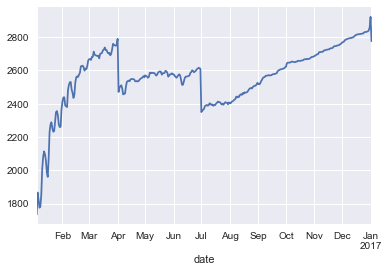

In [26]:
listing_calendar_df.loc[listing_calendar_df['available'] == True, ].groupby('date').available.count().plot()
plt.show()

The available listings kept increasing from January to April and the needs of AirBnB house increasing til July. And the needs of house/apt will decreasing.

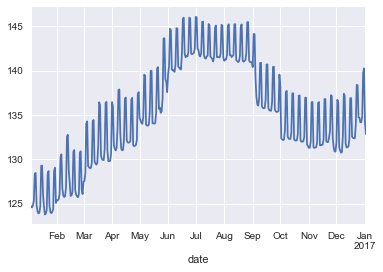

In [27]:
listing_calendar_df.groupby('date').price.mean().plot()
plt.show()

The price trend follows the needs of house available. The needs of house were high from april and consisted through the summer time. 

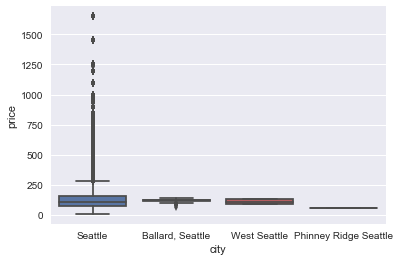

In [85]:
sns.boxplot(listing_calendar_df.price, groupby = listing_calendar_df.city)

The listings in Seattle had vary prices. And the prices of the listings of the other cities are in the range of 0-250 consistently.

In [43]:
listing_calendar_room_df = listing_calendar_df.loc[listing_calendar_df['available'] == True, ].groupby(['date', 'room_type']).available.sum()

In [55]:
listing_calendar_room_new_df = listing_calendar_room_df.reset_index()

,date,room_type,available
0,2016-01-04,Entire home/apt,1096.0
1,2016-01-04,Private room,580.0
2,2016-01-04,Shared room,59.0
3,2016-01-05,Entire home/apt,1160.0
4,2016-01-05,Private room,638.0


In [86]:
sns.lineplot(x=listing_calendar_room_new_df.date, y=listing_calendar_room_new_df.available
             , hue=listing_calendar_room_new_df.room_type)

AttributeError: 'module' object has no attribute 'lineplot'

In [70]:
listing_calendar_room_new_pivot_df = listing_calendar_room_new_df.pivot(index = 'date', columns = 'room_type', values = 'available')
listing_calendar_room_new_pivot_df = listing_calendar_room_new_pivot_df.reset_index()

room_type,date,Entire home/apt,Private room,Shared room
0,2016-01-04,1096.0,580.0,59.0
1,2016-01-05,1160.0,638.0,69.0
2,2016-01-06,1116.0,639.0,71.0
3,2016-01-07,1085.0,616.0,75.0
4,2016-01-08,1091.0,622.0,69.0


In [29]:
listing_calendar_df_lm = listing_calendar_df[['price', 'available', 'date', 'city', 'neighbourhood', 'host_since', 'host_is_superhost', 'room_type',
                                             'bed_type', 'beds', 'bedrooms', 'bathrooms'
                                            , 'minimum_nights', 'cancellation_policy', 'instant_bookable']]

In [30]:
listing_calendar_df_lm['host_since_days'] = (listing_calendar_df_lm['date'] - listing_calendar_df_lm['host_since']).astype('timedelta64[D]')

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
#need to convert the date into category
listing_calendar_df_lm['month'] = pd.DatetimeIndex(listing_calendar_df_lm['date']).month
listing_calendar_df_lm['month_cat'] = listing_calendar_df_lm['month'].astype('category')

In [32]:
listing_calendar_df_lm['month_cat'].dtype

category

In [33]:
listing_calendar_df_lm = pd.get_dummies(listing_calendar_df_lm[['price', 'available', 'month_cat', 'city', 'neighbourhood', 'host_since_days', 'host_is_superhost', 'room_type',
                                             'bed_type', 'beds', 'bedrooms', 'bathrooms'
                                            , 'minimum_nights', 'cancellation_policy', 'instant_bookable']], prefix_sep='_')

In [34]:
listing_calendar_df_lm.head()

,price,available,host_since_days,host_is_superhost,beds,bedrooms,bathrooms,minimum_nights,instant_bookable,month_cat_1,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,85.0,True,1607.0,False,1.0,1.0,1.0,1,False,1,...,0,0,0,0,0,0,1,0,1,0
1,85.0,True,1608.0,False,1.0,1.0,1.0,1,False,1,...,0,0,0,0,0,0,1,0,1,0
2,85.0,False,1609.0,False,1.0,1.0,1.0,1,False,1,...,0,0,0,0,0,0,1,0,1,0
3,85.0,False,1610.0,False,1.0,1.0,1.0,1,False,1,...,0,0,0,0,0,0,1,0,1,0
4,85.0,False,1611.0,False,1.0,1.0,1.0,1,False,1,...,0,0,0,0,0,0,1,0,1,0


In [35]:
def clean_fit_linear_mod(df, response_col, test_size=.3, rand_state=123):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''

    X = df.drop(response_col, axis = 1)
    y = df[response_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = rand_state)
    lm_model = LinearRegression(normalize = True)
    lm_model.fit(X_train, y_train)
    y_train_pred = lm_model.predict(X_train)
    y_test_pred = lm_model.predict(X_test)
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [36]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(listing_calendar_df_lm, 'price')

In [37]:
print(test_score, train_score)

(0.59209276970785552, 0.59221580456601575)


In [38]:
lm_model.coef_

array([  1.77855941e+01,   6.60299217e-04,   1.03836785e+01,
         1.31420985e+01,   4.02153443e+01,   3.27564148e+01,
        -8.72355694e-03,  -4.31511029e+00,  -2.26548061e+13,
        -2.26548061e+13,  -2.26548061e+13,  -2.26548061e+13,
        -2.26548061e+13,  -2.26548061e+13,  -2.26548061e+13,
        -2.26548061e+13,  -2.26548061e+13,  -2.26548061e+13,
        -2.26548061e+13,  -2.26548061e+13,   7.81853815e+13,
         7.81853815e+13,   7.81853815e+13,   7.81853815e+13,
        -2.54255951e+13,  -2.54255951e+13,  -2.54255951e+13,
        -2.54255951e+13,  -2.54255951e+13,  -2.54255951e+13,
        -2.54255951e+13,  -2.54255951e+13,  -2.54255951e+13,
        -2.54255951e+13,  -2.54255951e+13,  -2.54255951e+13,
        -2.54255951e+13,  -2.54255951e+13,  -2.54255951e+13,
        -2.54255951e+13,  -2.54255951e+13,  -2.54255951e+13,
        -2.54255951e+13,  -2.54255951e+13,  -2.54255951e+13,
        -2.54255951e+13,  -2.54255951e+13,  -2.54255951e+13,
        -2.54255951e+13,